In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jangedoo/utkface-new")

# print("Path to dataset files:", path)

import kagglehub
import os

# Set your desired local path
local_path = r"C:\Users\Kavitha padala\Desktop\data_scienc\datasets"

# Create directory if it doesn't exist
os.makedirs(local_path, exist_ok=True)

# Set kagglehub cache directory
kagglehub.cache_dir = local_path

# Download dataset
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Dataset downloaded to:", path)

100%|██████████| 331M/331M [00:06<00:00, 53.4MB/s] 

Extracting files...


Path to dataset files: C:\Users\Kavitha padala\.cache\kagglehub\datasets\jangedoo\utkface-new\versions\1


In [4]:
# !pip install kagglehub

In [1]:
### modules needed to be installed 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms.functional as F
import torchvision
import random
import time
import warnings
from torchvision.utils import make_grid


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
### read images and file names as well 

def read_images_and_labels(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(filename.split("_")[0])  # Assuming label is part of filename
    return images, labels

path = "./1/crop_part1"
images, labels = read_images_and_labels(path)


In [4]:
np.unique(labels)

array(['1', '10', '100', '101', '11', '110', '12', '13', '14', '15', '16',
       '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26',
       '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66',
       '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86',
       '87', '88', '89', '9', '90', '91', '92', '93', '95', '96', '99'],
      dtype='<U3')

In [5]:
images[0].shape

(200, 200, 3)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(int(label), dtype=torch.float32)
    
    

In [7]:
### transforming the  dataset 


transform  = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



dataset = ImageDataset(images, labels, transform=transform)



In [8]:

# Split the dataset into training and validation sets

test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, val_dataset = random_split(dataset, [train_size, test_size])


In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [10]:
### Let see the random images from train_loader 


def show_random_images(loader, num_images=5):
    images, labels = next(iter(loader))
    images = images[:num_images]
    labels = labels[:num_images]
    grid = make_grid(images, nrow=num_images)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title(f"Labels: {labels.numpy()}")
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


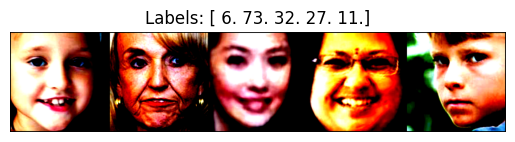

In [11]:
## Let see the images from train_loader
show_random_images(train_loader)

In [12]:
# ###  train the models 

# resnet_model = models.resnet18(pretrained=True)
# # resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 1)


# class ResNetRegression(nn.Module):
#     def __init__(self, base_model):
#         super(ResNetRegression, self).__init__()
#         self.base_model = base_model
#         self.fc = nn.Linear(base_model.fc.in_features, 1)

#     def forward(self, x):
#         x = self.base_model(x)
#         x = self.fc(x)
#         return x


# loss_fn = nn.MSELoss()
# optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)

# resnet_model = ResNetRegression(resnet_model).to(device)



# def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
#     for epoch in range(num_epochs):
#         model.train()
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = loss_fn(outputs, labels)
#             loss.backward()
#             optimizer.step()

#         model.eval()
#         with torch.no_grad():
#             val_loss = sum(loss_fn(model(images), labels) for images, labels in val_loader) / len(val_loader)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

### OPTION 1: Simple and Clean Fix
resnet_model = models.resnet18(pretrained=True)
# Replace the final classification layer for regression
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 1)  # 512 -> 1
resnet_model = resnet_model.to(device)

# Create loss function and optimizer AFTER model is finalized
loss_fn = nn.MSELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()  # Remove extra dimensions
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Print progress every 20 batches
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print("-" * 30)

# Now train the model
train_model(resnet_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)



c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 0, Loss: 1884.6418
Epoch 1, Batch 20, Loss: 862.6587
Epoch 1, Batch 40, Loss: 657.2102
Epoch 1, Batch 60, Loss: 473.0513
Epoch 1, Batch 80, Loss: 1014.2383
Epoch 1, Batch 100, Loss: 532.9830
Epoch 1, Batch 120, Loss: 548.1990
Epoch 1, Batch 140, Loss: 213.8733
Epoch 1, Batch 160, Loss: 539.3957
Epoch 1, Batch 180, Loss: 619.7349
Epoch 1, Batch 200, Loss: 368.5694
Epoch 1, Batch 220, Loss: 383.1191
Epoch 1, Batch 240, Loss: 152.2385
Epoch 1/10
  Train Loss: 704.0213
  Val Loss: 277.9573
------------------------------
Epoch 2, Batch 0, Loss: 1150.2063
Epoch 2, Batch 20, Loss: 223.4883
Epoch 2, Batch 40, Loss: 145.2260
Epoch 2, Batch 60, Loss: 276.9711
Epoch 2, Batch 80, Loss: 82.8133
Epoch 2, Batch 100, Loss: 141.9867
Epoch 2, Batch 120, Loss: 126.4931
Epoch 2, Batch 140, Loss: 131.4854
Epoch 2, Batch 160, Loss: 150.8980
Epoch 2, Batch 180, Loss: 55.5336
Epoch 2, Batch 200, Loss: 353.9827
Epoch 2, Batch 220, Loss: 64.4359
Epoch 2, Batch 240, Loss: 72.8905
Epoch 2/10
  Trai

In [35]:
# ### train the loader FOR REGRESSION

# train_model(resnet_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

In [36]:
eval_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, eval_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        total_loss = sum(loss_fn(model(images.to(device)), labels.to(device)) for images, labels in eval_loader)
    return total_loss / len(eval_loader)


In [37]:
evaluate_model(resnet_model, eval_loader, loss_fn)

c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1087.3684, device='cuda:0')

In [87]:
### Train the EfficientNet Model

efficientnet_model = models.efficientnet_b0(pretrained=True)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 1)
efficientnet_model = efficientnet_model.to(device)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=1e-4)

train_model(efficientnet_model, train_loader, val_loader, loss_fn, efficientnet_optimizer, num_epochs=10)


c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 0, Loss: 1171.5524
Epoch 1, Batch 20, Loss: 1565.9084
Epoch 1, Batch 40, Loss: 1903.3096
Epoch 1, Batch 60, Loss: 699.4719
Epoch 1, Batch 80, Loss: 1271.6692
Epoch 1, Batch 100, Loss: 731.1665
Epoch 1, Batch 120, Loss: 319.1339
Epoch 1, Batch 140, Loss: 445.3791
Epoch 1, Batch 160, Loss: 374.1093
Epoch 1, Batch 180, Loss: 650.2731
Epoch 1, Batch 200, Loss: 379.4726
Epoch 1, Batch 220, Loss: 661.8920
Epoch 1, Batch 240, Loss: 371.2000
Epoch 1/10
  Train Loss: 793.9756
  Val Loss: 307.1777
------------------------------
Epoch 2, Batch 0, Loss: 531.0178
Epoch 2, Batch 20, Loss: 304.3603
Epoch 2, Batch 40, Loss: 419.4120
Epoch 2, Batch 60, Loss: 418.4588
Epoch 2, Batch 80, Loss: 358.9244
Epoch 2, Batch 100, Loss: 477.3968
Epoch 2, Batch 120, Loss: 136.4456
Epoch 2, Batch 140, Loss: 263.6758
Epoch 2, Batch 160, Loss: 152.8578
Epoch 2, Batch 180, Loss: 293.9156
Epoch 2, Batch 200, Loss: 158.0457
Epoch 2, Batch 220, Loss: 218.5296
Epoch 2, Batch 240, Loss: 152.9563
Epoch 2/10
 

In [88]:

## testing the model with random images predictions 


def random_images_test(model, num_images=5):
    model.eval()
    with torch.no_grad():
        for _ in range(num_images):
            # Get a random image from the dataset
            image, label = dataset[np.random.randint(0, len(dataset))]
            image = image.unsqueeze(0).to(device)

            # Make a prediction
            
            output = model(image)
            print(f"Predicted: {output.item()}")
            print(f"Actual: {label}")


In [89]:
### random images test for resnet 

random_images_test(resnet_model, num_images=5)

Predicted: 14.527301788330078
Actual: 14.0
Predicted: 16.63854217529297
Actual: 22.0
Predicted: 23.552255630493164
Actual: 24.0
Predicted: 1.1893901824951172
Actual: 1.0
Predicted: 5.488433361053467
Actual: 8.0


In [90]:
random_images_test(efficientnet_model, num_images=5)

Predicted: 51.12983703613281
Actual: 54.0
Predicted: 0.8839925527572632
Actual: 1.0
Predicted: 1.9743787050247192
Actual: 4.0
Predicted: 1.8363678455352783
Actual: 2.0
Predicted: 32.53064727783203
Actual: 38.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 11.845592498779297
Actual: 10.0


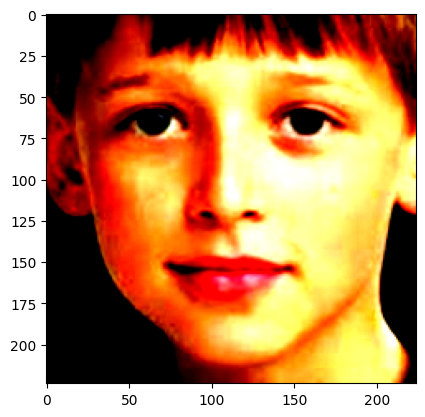

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 10.452285766601562
Actual: 10.0


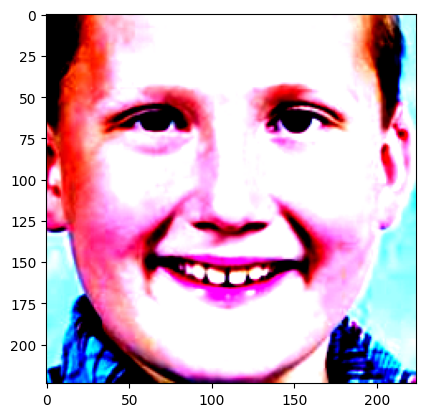

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 6.874998092651367
Actual: 10.0


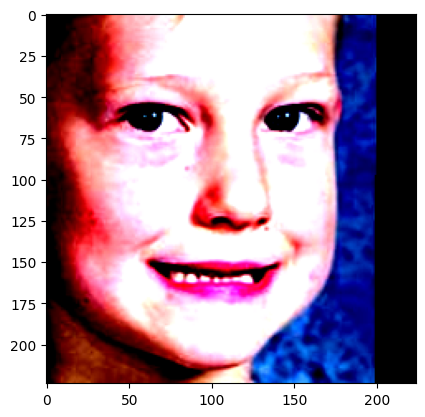

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 11.436460494995117
Actual: 10.0


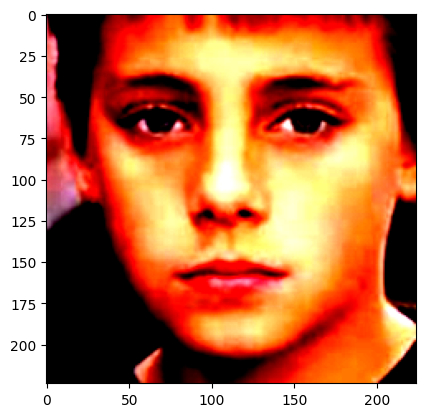

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 10.482503890991211
Actual: 10.0


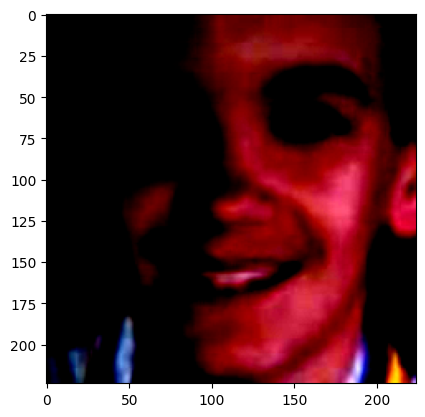

In [91]:
### let see the images and predictions and acutal labels as well 

for i in range(3,8):
    image, label = dataset[i]
    image = image.unsqueeze(0).to(device)

    # Make a prediction
    output = efficientnet_model(image)
    print(f"Predicted: {output.item()}")
    print(f"Actual: {label}")
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
    plt.show()

In [93]:
# effficientnet_model = models.efficientnet_b0(pretrained=True)

# effficientnet_model

In [94]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)


save_model(efficientnet_model, "efficientnet_model_regression_age_detection.pth")
save_model(resnet_model, "resnet_model_regression_age_detection.pth")


In [21]:
### testing real image  
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def test_real_image(model, image_path,transform,name):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        print(f"Predicted: {output.item()}")
        plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
        plt.title(name)
        plt.show()


Predicted: 22.28797721862793


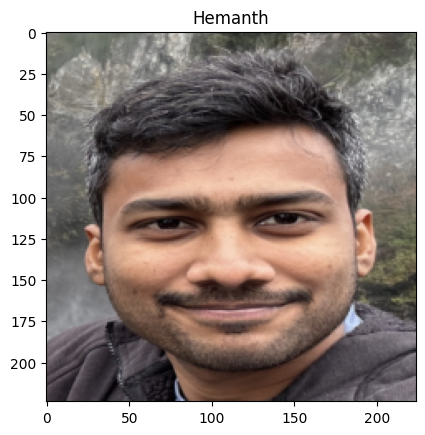

In [107]:
image_path = "./data/IMG_4128.jpg"




test_real_image(resnet_model, image_path,transform,"Hemanth")


In [18]:
### Now test the metrics of the model 

from sklearn.metrics import mean_squared_error, r2_score


def test_model_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    mse = mean_squared_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

    

In [104]:
test_model_metrics(efficientnet_model, val_loader)


Mean Squared Error: 55.109779357910156
R^2 Score: 0.9058290818483529


In [105]:
test_model_metrics(resnet_model, val_loader)

Mean Squared Error: 49.04665756225586
R^2 Score: 0.9161896720965413


In [109]:
### for vision models 
!pip install timm


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.8 kB 960.0 kB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   --------------------- ------------------ 1.4/2.5 MB 41.9 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 39.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a small ViT (vit_tiny_patch16_224)
vit_model = create_model('vit_tiny_patch16_224', pretrained=True)

# Replace classifier head with 1 output neuron for regression
if hasattr(vit_model, 'head'):
    vit_model.head = nn.Linear(vit_model.head.in_features, 1)
elif hasattr(vit_model, 'fc'):
    vit_model.fc = nn.Linear(vit_model.fc.in_features, 1)

vit_model = vit_model.to(device)

# Optimizer and Loss
optimizer_vit = optim.Adam(vit_model.parameters(), lr=1e-4)
loss_fn = nn.L1Loss()  # MAE loss for regression


In [14]:
for name, param in vit_model.named_parameters():
    if "blocks" in name:  # freeze transformer blocks
        param.requires_grad = False

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).float()
            labels = labels.float().view(-1, 1) 
            optimizer.zero_grad()
            outputs = model(images).squeeze()  # Remove extra dimensions
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print("-" * 30)


In [15]:
# torch.cuda.empty_cache()


In [16]:
train_model(vit_model, train_loader, val_loader, loss_fn, optimizer_vit, num_epochs=10)


c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\layers\attention.py:80: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1, Batch 0, Loss: 31.7374
Epoch 1, Batch 20, Loss: 27.2710
Epoch 1, Batch 40, Loss: 34.0640
Epoch 1, Batch 60, Loss: 23.9762
Epoch 1, Batch 80, Loss: 15.4891
Epoch 1, Batch 100, Loss: 24.8002
Epoch 1, Batch 120, Loss: 20.6282
Epoch 1, Batch 140, Loss: 20.7993
Epoch 1, Batch 160, Loss: 18.1216
Epoch 1, Batch 180, Loss: 21.8233
Epoch 1, Batch 200, Loss: 21.7711
Epoch 1, Batch 220, Loss: 22.0264
Epoch 1, Batch 240, Loss: 17.6854


c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/10
  Train Loss: 22.8548
  Val Loss: 19.9437
------------------------------
Epoch 2, Batch 0, Loss: 22.3805
Epoch 2, Batch 20, Loss: 17.4341
Epoch 2, Batch 40, Loss: 21.0427
Epoch 2, Batch 60, Loss: 22.8506
Epoch 2, Batch 80, Loss: 20.8876
Epoch 2, Batch 100, Loss: 21.9737
Epoch 2, Batch 120, Loss: 21.5422
Epoch 2, Batch 140, Loss: 16.9303
Epoch 2, Batch 160, Loss: 23.2315
Epoch 2, Batch 180, Loss: 18.0596
Epoch 2, Batch 200, Loss: 22.4562
Epoch 2, Batch 220, Loss: 17.7994
Epoch 2, Batch 240, Loss: 20.5701
Epoch 2/10
  Train Loss: 20.6554
  Val Loss: 19.9555
------------------------------
Epoch 3, Batch 0, Loss: 21.2747
Epoch 3, Batch 20, Loss: 23.1627
Epoch 3, Batch 40, Loss: 25.9862
Epoch 3, Batch 60, Loss: 17.7363
Epoch 3, Batch 80, Loss: 17.7648
Epoch 3, Batch 100, Loss: 18.0943
Epoch 3, Batch 120, Loss: 20.8366
Epoch 3, Batch 140, Loss: 22.6917
Epoch 3, Batch 160, Loss: 18.2909
Epoch 3, Batch 180, Loss: 16.0512
Epoch 3, Batch 200, Loss: 22.3263
Epoch 3, Batch 220, Loss: 18

In [19]:
test_model_metrics(vit_model, val_loader)

Mean Squared Error: 611.72021484375
R^2 Score: -0.03729846848602114


Predicted: 4.460176467895508


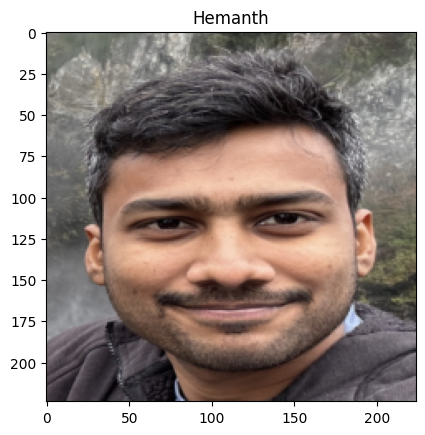

In [23]:
image_path = "./data/IMG_4128.jpg"




test_real_image(vit_model, image_path, transform, "Hemanth")

In [ ]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

import joblib
import os 
import torch
def load_model(model_path):
    model = torch.load(model_path)
    return model


resnet_model = load_model("resnet_model_regression_age_detection.pth")

C:\Users\Kavitha padala\AppData\Local\Temp\ipykernel_23384\825507841.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_regression_model(model_path, model_type='resnet18', num_classes=1):
    """
    Properly load a saved regression model with full architecture recreation
    
    Args:
        model_path (str): Path to the saved model file
        model_type (str): Type of model ('resnet18', 'efficientnet_b0', etc.)
        num_classes (int): Number of output classes (1 for regression)
    
    Returns:
        torch.nn.Module: Loaded model ready for inference
    """
    try:
        # Check if model file exists
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")
        
        print(f"🔄 Loading {model_type} model from {model_path}")
        
        # Recreate the model architecture
        if model_type.lower() == 'resnet18':
            model = models.resnet18(weights=None)  # Don't load pretrained weights
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            
        elif model_type.lower() == 'efficientnet_b0':
            model = models.efficientnet_b0(weights=None)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
            
        elif model_type.lower() == 'vit':
            from timm import create_model
            model = create_model('vit_tiny_patch16_224', pretrained=False)
            if hasattr(model, 'head'):
                model.head = nn.Linear(model.head.in_features, num_classes)
            elif hasattr(model, 'fc'):
                model.fc = nn.Linear(model.fc.in_features, num_classes)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
        
        # Load the saved state dict
        try:
            # Try loading the state dict (if saved with torch.save(model.state_dict()))
            state_dict = torch.load(model_path, map_location=device)
            model.load_state_dict(state_dict)
            print("✅ Loaded state_dict successfully")
            
        except Exception as e1:
            try:
                # Try loading the full model (if saved with torch.save(model))
                model = torch.load(model_path, map_location=device)
                print("✅ Loaded full model successfully")
                
            except Exception as e2:
                print(f"❌ Failed to load state_dict: {e1}")
                print(f"❌ Failed to load full model: {e2}")
                raise Exception("Could not load model with either method")
        
        # Move model to device and set to evaluation mode
        model = model.to(device)
        model.eval()
        
        print(f"✅ Model loaded successfully on {device}")
        return model
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None

# Load your saved models with proper architecture
print("🚀 Loading saved regression models...")

# Load ResNet model
resnet_model = load_regression_model(
    "resnet_model_regression_age_detection.pth", 
    model_type='resnet18'
)

# Load EfficientNet model (if available)
if os.path.exists("efficientnet_model_regression_age_detection.pth"):
    efficientnet_model = load_regression_model(
        "efficientnet_model_regression_age_detection.pth", 
        model_type='efficientnet_b0'
    )
else:
    print("ℹ️ EfficientNet model file not found")
    efficientnet_model = None

# Verify model loading with a simple test
if resnet_model is not None:
    print("\n🧪 Testing ResNet model...")
    test_input = torch.randn(1, 3, 224, 224).to(device)
    
    with torch.no_grad():
        test_output = resnet_model(test_input)
        print(f"✅ ResNet test passed - Output shape: {test_output.shape}")
        print(f"   Sample prediction: {test_output.item():.2f}")

def create_inference_pipeline(model, transform=None):
    """
    Create a complete inference pipeline for age prediction
    
    Args:
        model: Loaded PyTorch model
        transform: Image preprocessing transform
    
    Returns:
        function: Inference function
    """
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def predict_age(image_path_or_array, show_image=True):
        """
        Predict age from image
        
        Args:
            image_path_or_array: Path to image file or numpy array
            show_image: Whether to display the image
        
        Returns:
            float: Predicted age
        """
        try:
            # Load image
            if isinstance(image_path_or_array, str):
                if not os.path.exists(image_path_or_array):
                    print(f"❌ Image not found: {image_path_or_array}")
                    return None
                image = Image.open(image_path_or_array).convert('RGB')
                title = os.path.basename(image_path_or_array)
            else:
                image = Image.fromarray(image_path_or_array).convert('RGB')
                title = "Input Image"
            
            # Preprocess
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            # Predict
            model.eval()
            with torch.no_grad():
                prediction = model(input_tensor)
                predicted_age = prediction.item()
            
            # Display results
            if show_image:
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.title(f'{title}\nPredicted Age: {predicted_age:.1f} years')
                plt.axis('off')
                plt.tight_layout()
                plt.show()
            
            return predicted_age
            
        except Exception as e:
            print(f"❌ Prediction error: {str(e)}")
            return None
    
    return predict_age

# Create inference pipelines
if resnet_model is not None:
    resnet_predictor = create_inference_pipeline(resnet_model)
    
    # Test with your images
    print("\n🔍 Testing ResNet predictions...")
    
    # Test image paths
    test_images = [
        "./data/IMG_4128.jpg",
        "./data/IMG_4779.jpg"
    ]
    
    for img_path in test_images:
        if os.path.exists(img_path):
            print(f"\n📸 Predicting for {img_path}:")
            predicted_age = resnet_predictor(img_path)
            if predicted_age:
                print(f"   Predicted age: {predicted_age:.1f} years")
        else:
            print(f"⚠️ Image not found: {img_path}")

def load_data(file_path):
    """
    Load CSV data with error handling
    
    Args:
        file_path (str): Path to CSV file
    
    Returns:
        pd.DataFrame or None: Loaded data or None if failed
    """
    try:
        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            return None
        
        data = pd.read_csv(file_path)
        print(f"✅ Data loaded successfully from {file_path}")
        print(f"   Shape: {data.shape}")
        return data
        
    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        return None

def save_model_properly(model, filename, model_type='resnet18'):
    """
    Save model with proper metadata
    
    Args:
        model: PyTorch model to save
        filename: Output filename
        model_type: Type of model for metadata
    """
    try:
        # Save both state dict and metadata
        save_dict = {
            'state_dict': model.state_dict(),
            'model_type': model_type,
            'device': str(next(model.parameters()).device),
            'architecture': str(model)
        }
        
        torch.save(save_dict, filename)
        print(f"✅ Model saved successfully to {filename}")
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")

# Enhanced model comparison function
def compare_models(*models, test_images=None):
    """
    Compare multiple models on test images
    
    Args:
        *models: Variable number of (model, name) tuples
        test_images: List of test image paths
    """
    if test_images is None:
        test_images = ["./data/IMG_4128.jpg"]

    results = {}
    
    for model, name in models:
        if model is not None:
            predictor = create_inference_pipeline(model)
            results[name] = []
            
            print(f"\n🔍 Testing {name}:")
            for img_path in test_images:
                if os.path.exists(img_path):
                    pred = predictor(img_path, show_image=False)
                    results[name].append(pred)
                    print(f"  {os.path.basename(img_path)}: {pred:.1f} years")
    
    # Create comparison visualization
    if len(results) > 1:
        fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))
        if len(test_images) == 1:
            axes = [axes]
        
        for i, img_path in enumerate(test_images):
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[i].imshow(img)
                
                # Add predictions as text
                pred_text = "\n".join([f"{name}: {preds[i]:.1f}" 
                                     for name, preds in results.items() 
                                     if len(preds) > i and preds[i] is not None])
                
                axes[i].set_title(f"{os.path.basename(img_path)}\n{pred_text}")
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return results

# Compare models if both are available
if resnet_model is not None:
    if efficientnet_model is not None:
        print("\n📊 Comparing ResNet vs EfficientNet:")
        comparison_results = compare_models(
            (resnet_model, "ResNet18"),
            (efficientnet_model, "EfficientNet-B0")
        )
    else:
        print("\n📊 Testing ResNet model:")
        comparison_results = compare_models(
            (resnet_model, "ResNet18")
        )

print("\n✅ Model loading and inference pipeline setup complete!")

Using device: cuda
🚀 Loading saved regression models...
❌ Error loading model: Model file not found: resnet_model_regression_age_detection.pth
ℹ️ EfficientNet model file not found

✅ Model loading and inference pipeline setup complete!


In [33]:
import timm
import torch.nn as nn

model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)
model.head = nn.Linear(model.head.in_features, 1)  # 1 for regression output
model = model.to(device)

In [35]:

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# train_model(model, train_loader,val_loader, criterion, optimizer, num_epochs=10)

In [31]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (